In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from fastai import *
from fastai.vision import *

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
path_train=Path("../input/train.csv")
path_test=Path("../input/test.csv")
path_sam_submit=Path("../input/sample_submission.csv")

In [3]:
traincsv=pd.read_csv(path_train)
testcsv=pd.read_csv(path_test)

In [4]:
traincsv.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
testcsv.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
class CustomImageItemList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res
    
test = CustomImageItemList.from_csv_custom(path=path_test,csv_name='' ,imgIdx=0)

data = (CustomImageItemList.from_csv_custom(path=path_train,csv_name='' )
                       .random_split_by_pct(.05)
                       .label_from_df(cols='label')
                       .add_test(test, label=0)
                       .databunch(bs=64, num_workers=0))

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:212: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [7]:
data.c, len(data.classes)

(10, 10)

In [8]:
learn = cnn_learner(data,models.resnet50, metrics=accuracy, model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 24088923.91it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


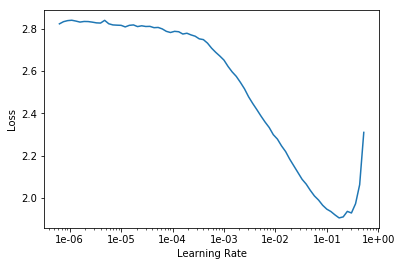

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(2,slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.254283,0.140381,0.958571,00:37
1,0.104494,0.086114,0.973810,00:37


In [11]:
learn.save('stage-1')

In [12]:
learn.fit_one_cycle(2,slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.124306,0.079929,0.977619,00:36
1,0.068858,0.049516,0.983810,00:36


In [13]:
learn.save('stage-2')

In [14]:
learn.fit_one_cycle(2,max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.054528,0.045923,0.985238,00:37
1,0.033864,0.045996,0.985714,00:36


In [15]:
learn.fit_one_cycle(2,slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.037230,0.048551,0.984286,00:36
1,0.040215,0.048956,0.983333,00:36


In [16]:
learn.save('stage-3')

In [17]:
learn.fit_one_cycle(2,slice(3e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.204290,0.515841,0.964762,00:36
1,0.053322,0.038910,0.989048,00:37


In [18]:
learn.save('stage-4')

In [19]:
learn.fit_one_cycle(2,slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.055078,0.050612,0.984286,00:36
1,0.026751,0.429387,0.988571,00:36


In [20]:
learn.save('stage-5')

In [21]:
# learn.fit_one_cycle(2,slice(1e-2))

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


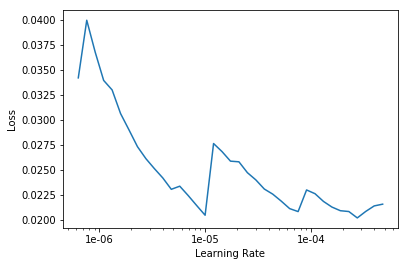

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2,slice(2e-6,1e-2/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.035539,0.040243,0.988095,00:46
1,0.022060,0.031502,0.991905,00:46


In [25]:
learn.save('stage-6')

In [26]:
learn.fit_one_cycle(2,slice(2e-6,1e-2/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.027695,0.037999,0.989048,00:46
1,0.012343,0.031462,0.992381,00:46


In [27]:
learn.save('stage-7')
learn.unfreeze()

In [28]:
learn.fit_one_cycle(2,slice(2e-6,1e-2/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.026149,0.199276,0.988095,00:47
1,0.007413,0.036796,0.992857,00:46


In [29]:
learn.load('stage-8')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/models/stage-8.pth'

In [30]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)